# Benchmark adding two 1-D XND arrays

This is a very basic benchmark, intended to get a first impression of XND.
Here we compare three methods to add two 1-D arrays: with `numpy`, with `xnd.array` (which supports the Python `+` operator since recently) and with `gumath`'s `add` gufunc.

In [1]:
import timeit

import numpy as np
import xnd
from gumath import functions as fn

import matplotlib.pyplot as plt

In [2]:
x = np.arange(5)
y = np.ones_like(x)

timeit.timeit('x + y', number=50000, globals=globals())

0.03312677000940312

In [3]:
x2 = xnd.xnd.from_buffer(x)
y2 = xnd.xnd.from_buffer(y)

timeit.timeit('fn.add(x2, y2)', number=10000, globals=globals())

0.025241898008971475

In [4]:
x3 = xnd.array(x.tolist())
y3 = xnd.array(y.tolist())

timeit.timeit('x3 + y3', number=10000, globals=globals())

0.0436678449914325

In [16]:
def time_operator(timing_func, operator_name, save=False):
    def time_sizes(lib, dtype, n_loops=10000):
        times = []
        for size in sizes:
            times.append(timing_func(size, lib=lib, n_loops=n_loops))

        return times 


    sizes = 2**np.arange(2, 25)  # 2**16 -> ~65000,  2**22 -> ~4e6
    n_loops = 10000

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for i_ax, dtype in enumerate(['int', 'float']):
        for lib in ('numpy', 'gumath', 'xnd.array'):
            ax[i_ax].loglog(sizes, time_sizes(lib, dtype, n_loops), 'o-', label=lib)

        ax[i_ax].grid(True)
        ax[i_ax].set_xlabel('Array size (1D)')
        ax[i_ax].set_ylabel('Time per {} loops (sec))'.format(n_loops))
        ax[i_ax].set_title('{} ({})'.format(operator_name, dtype))

    ax[0].legend(loc='best', numpoints=1)

    if save:
        fig.savefig('benchmark_xnd_{}.png'.format(operator_name))

    return fig, ax

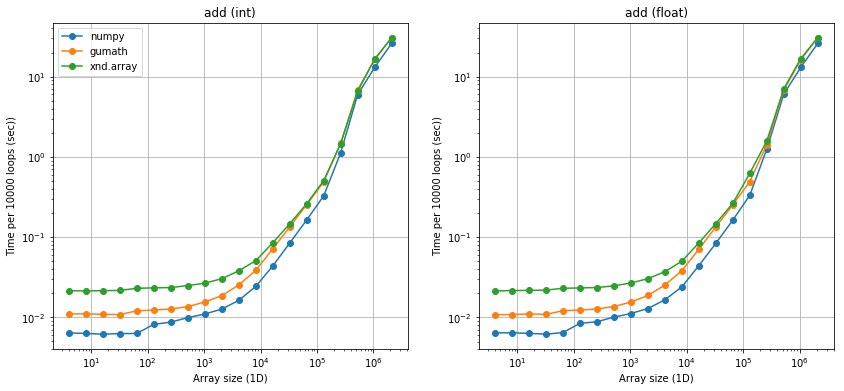

In [12]:
def time_add(size, lib='numpy', dtype=int, n_loops=10000):
    x = np.arange(size, dtype=dtype)
    y = np.ones_like(x)
    if lib == 'numpy':
        expr = 'x + y'
    elif lib == 'gumath':
        x2 = xnd.xnd.from_buffer(x)
        y2 = xnd.xnd.from_buffer(y)
        expr = 'fn.add(x2, y2)'
    elif lib == 'xnd.array':
        x3 = xnd.array(x.tolist())
        y3 = xnd.array(y.tolist())
        expr = 'x3 + y3'   
    else:
        raise ValueError('Unrecognized `lib`: {}'.format(lib))
    
    namespace = locals().copy()
    namespace['fn'] = fn
    # Timeit doesn't figure out number of repetitions automatically,
    # unless used via `python -m timeit`
    div = np.log2(size)
    return div * min(timeit.repeat(expr, number=int(n_loops/div), globals=namespace))


time_operator(time_add, 'add', save=True)

plt.show()

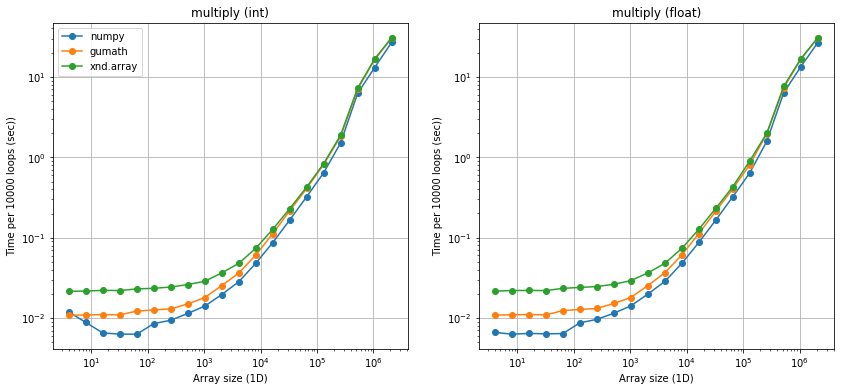

In [13]:
def time_multiply(size, lib='numpy', dtype=int, n_loops=10000):
    x = np.arange(size, dtype=dtype)
    y = np.ones_like(x)
    if lib == 'numpy':
        expr = 'x * y'
    elif lib == 'gumath':
        x2 = xnd.xnd.from_buffer(x)
        y2 = xnd.xnd.from_buffer(y)
        expr = 'fn.multiply(x2, y2)'
    elif lib == 'xnd.array':
        x3 = xnd.array(x.tolist())
        y3 = xnd.array(y.tolist())
        expr = 'x3 * y3'   
    else:
        raise ValueError('Unrecognized `lib`: {}'.format(lib))
    
    namespace = locals().copy()
    namespace['fn'] = fn
    # Timeit doesn't figure out number of repetitions automatically,
    # unless used via `python -m timeit`
    div = np.log2(size)
    return div * min(timeit.repeat(expr, number=int(n_loops/div), globals=namespace))


fig, axes = time_operator(time_multiply, 'multiply', save=False)

plt.show()

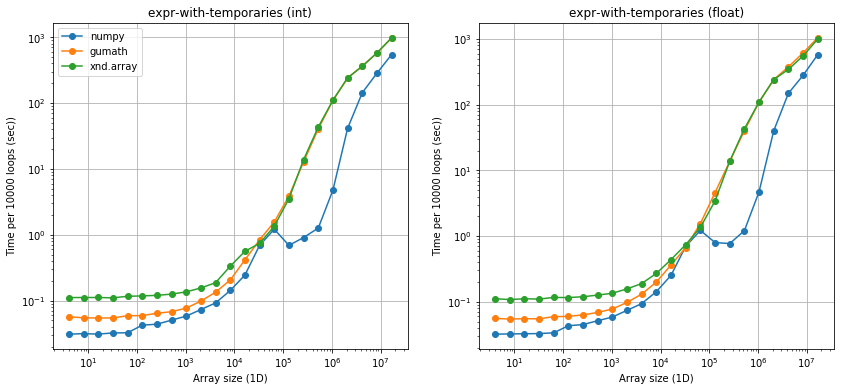

In [17]:
def time_expr_with_temporaries(size, lib='numpy', dtype=float, n_loops=10000):
    x = np.arange(1, size+1, dtype=dtype)
    y = np.ones_like(x)
    if lib == 'numpy':
        expr = 'x * y + x + y*x - y'
    elif lib == 'gumath':
        x2 = xnd.xnd.from_buffer(x)
        y2 = xnd.xnd.from_buffer(y)
        expr = 'fn.subtract(fn.add(fn.add(fn.multiply(x2, y2), x2), fn.multiply(y2, x2)), y2)'
    elif lib == 'xnd.array':
        x3 = xnd.array(x.tolist())
        y3 = xnd.array(y.tolist())
        expr = 'x3 * y3 + x3 + y3*x3 - y3'   
    else:
        raise ValueError('Unrecognized `lib`: {}'.format(lib))
    
    namespace = locals().copy()
    namespace['fn'] = fn
    # Timeit doesn't figure out number of repetitions automatically,
    # unless used via `python -m timeit`
    div = np.log2(size)
    return div * min(timeit.repeat(expr, number=int(n_loops/div), globals=namespace))


fig, axes = time_operator(time_expr_with_temporaries, 'expr-with-temporaries', save=True)

plt.show()

## Speeding this up a bit

The above benchmarks are *really* slow (order 30 minutes for the expression with temporaries and sizes till `2**25`). We also see that `int` and `float` are typically the same, and that the overhead of `xnd.array` is high but that for large arrays `xnd.array` and `gumath` are the same.

`xnd.array` is much easier to use than `gumath`, so let's just use that and ignore the small-array overhead (it's not very interesting; at some point the implementation will be rewritten in C and then it'll be the same as `gumath`).

In [26]:
def time_operator(timing_func, operator_name, save=False):
    def time_sizes(lib, dtype, n_loops=2000):
        times = []
        for size in sizes:
            times.append(timing_func(size, lib=lib, n_loops=n_loops))

        return times 


    sizes = 2**np.arange(2, 21)  # 2**16 -> ~65000,  2**22 -> ~4e6
    n_loops = 10000
    dtype = float
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    
    for lib in ('numpy', 'xnd.array'):
        ax.loglog(sizes, time_sizes(lib, dtype, n_loops), 'o-', label=lib)

    ax.grid(True)
    ax.set_xlabel('Array size (1D)')
    ax.set_ylabel('Time per {} loops (sec))'.format(n_loops))
    ax.set_title('{} ({})'.format(operator_name, dtype))

    ax.legend(loc='best', numpoints=1)

    if save:
        fig.savefig('benchmark_xnd_{}_float.png'.format(operator_name))

    return fig, ax

TypeError: 'AxesSubplot' object is not subscriptable

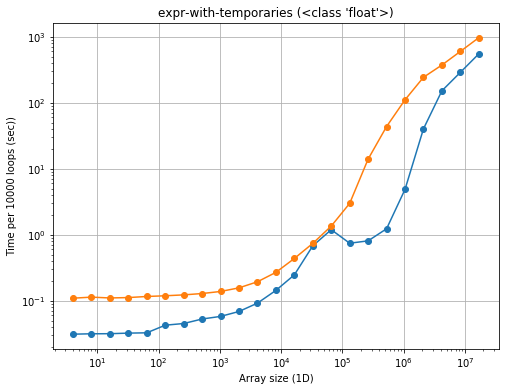

In [19]:
def time_expr_with_temporaries(size, lib='numpy', dtype=float, n_loops=10000):
    x = np.arange(1, size+1, dtype=dtype)
    y = np.ones_like(x)
    if lib == 'numpy':
        expr = 'x * y + x + y*x - y'
    elif lib == 'xnd.array':
        x3 = xnd.array(x.tolist())
        y3 = xnd.array(y.tolist())
        expr = 'x3 * y3 + x3 + y3*x3 - y3'   
    else:
        raise ValueError('Unrecognized `lib`: {}'.format(lib))
    
    namespace = locals().copy()
    namespace['fn'] = fn
    # Timeit doesn't figure out number of repetitions automatically,
    # unless used via `python -m timeit`
    div = np.log2(size)
    return div * min(timeit.repeat(expr, number=int(n_loops/div), globals=namespace))


fig, axes = time_operator(time_expr_with_temporaries, 'expr-with-temporaries', save=False)

plt.show()

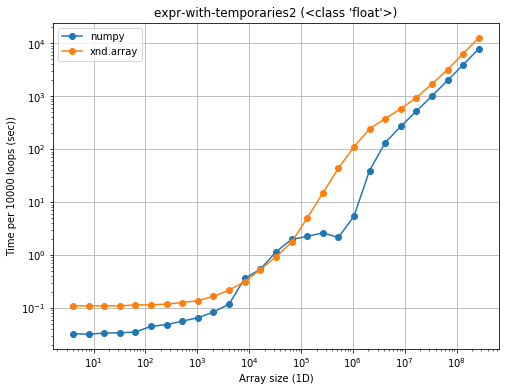

In [25]:
def time_expr_with_temporaries2(size, lib='numpy', dtype=float, n_loops=2000):
    x = np.arange(1, size+1, dtype=dtype)
    y = np.ones_like(x)
    if lib == 'numpy':
        expr = 'x/y - x + y/x - y'
    elif lib == 'xnd.array':
        x3 = xnd.array(x.tolist())
        y3 = xnd.array(y.tolist())
        expr = 'x3/y3 - x3 + y3/x3 - y3'   
    else:
        raise ValueError('Unrecognized `lib`: {}'.format(lib))
    
    namespace = locals().copy()
    namespace['fn'] = fn
    # Timeit doesn't figure out number of repetitions automatically,
    # unless used via `python -m timeit`
    div = np.log2(size)
    return div * min(timeit.repeat(expr, number=int(n_loops/div), globals=namespace))


fig, axes = time_operator(time_expr_with_temporaries2, 'expr-with-temporaries2', save=True)

plt.show()

I've had another go with an expression that should be friendlier to XND (`x/y - x + y/x - y`). Stefan predicted that XND should be faster due to its automatic multithreading (which NumPy doesn't do). Unfortunately I have an Anaconda build of NumPy installed, which does multithreading as well (and uses SVML)). So still not faster. If I disable the Intel optimizations with `export OMP_NUM_THREADS=1` though, we get back to "stock numpy" like performance which is 3x worse than in this graph. 